In [1]:
pip install transformers datasets evaluate accelerate peft scikit-learn matplotlib wandb


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from transformers import RobertaModel, RobertaTokenizer, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from peft import LoraConfig, get_peft_model
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import evaluate
import json
import numpy as np
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

In [2]:
with open('datasets/dataset_general.jsonl', 'r') as f:
        json_list = list(f)

with open('datasets/dataset_general_add.jsonl', 'r') as f2:
    json_list_additional = list(f2)

entries = []
distinct_code_samples = set()
for json_str in json_list:
    json_str = json.loads(json_str)

    if json_str['code_with_error'] and json_str['groundTruthError']: 
        entry = {}
        entry['text'] = json_str['code_with_error']
        entry['label'] = json_str['groundTruthError']['trace']
        entries.append(entry)
        distinct_code_samples.add(entry['text'])

for json_str in json_list_additional:
    json_str = json.loads(json_str)

    if json_str['code_with_error'] and json_str['groundTruthError']: 
        if not json_str['code_with_error'] in distinct_code_samples:
            entry = {}
            entry['text'] = json_str['code_with_error']
            entry['label'] = json_str['groundTruthError']['trace']
            entries.append(entry)
            distinct_code_samples.add(entry['text'])

dataset = Dataset.from_list(entries)

dataset_copy = Dataset.from_list(entries)
dataset_copy.set_format(type='pandas')
df = dataset_copy[:].sample(frac = 1)

In [3]:
df['label'].value_counts()

label
NameError              132
SyntaxError            128
ValueError              47
IndexError              20
TypeError               10
EOFError                 2
RecursionError           1
ModuleNotFoundError      1
Name: count, dtype: int64

In [4]:
import matplotlib.pyplot as plt

label_counts = df['label'].value_counts()
df = df[df['label'].isin(label_counts[label_counts >= 2].index)]

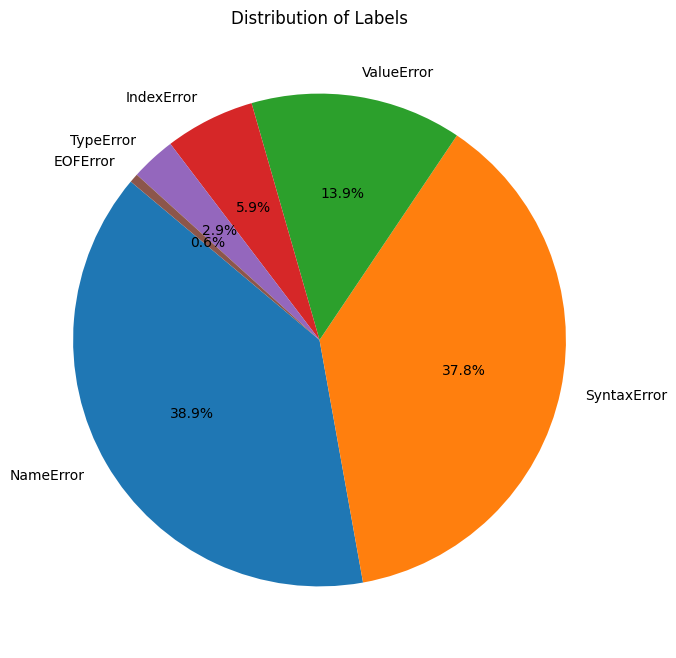

In [5]:
import matplotlib.pyplot as plt

value_counts = df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
plt.title('Distribution of Labels')
plt.show()

In [6]:
# Labels to integers
label2int = {label: i for i, label in enumerate(df['label'].unique())}
int2label = {i: label for label, i in label2int.items()}
df['label'] = df['label'].map(label2int)

In [7]:
df['label'].value_counts()

label
0    132
1    128
4     47
3     20
2     10
5      2
Name: count, dtype: int64

In [8]:
label_counts = df['label'].value_counts()
df = df[df['label'].isin(label_counts[label_counts >= 5].index)]

In [9]:
df['label'].value_counts()

label
0    132
1    128
4     47
3     20
2     10
Name: count, dtype: int64

In [10]:
# As unbalanced, will use stratified split + do weighted loss
weights = 1 / df['label'].value_counts(normalize=True).sort_index().values
weights = torch.tensor(weights / weights.sum(), dtype=torch.float32)
weights

tensor([0.0406, 0.0419, 0.5357, 0.2679, 0.1140])

In [11]:
df['label'].value_counts()

label
0    132
1    128
4     47
3     20
2     10
Name: count, dtype: int64

In [12]:
dataset = Dataset.from_pandas(df)
dataset = dataset.remove_columns('__index_level_0__')
dataset = dataset.class_encode_column("label")

Stringifying the column:   0%|          | 0/337 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/337 [00:00<?, ? examples/s]

In [13]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 337
})

In [14]:
train_testvalid = dataset.train_test_split(test_size=0.3, shuffle=True, stratify_by_column='label')
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, shuffle=True, stratify_by_column='label')

dataset = DatasetDict({
    'train': train_testvalid['train'],
    'validation': test_valid['train'],
    'test': test_valid['test']
})

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 235
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 51
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 51
    })
})

# Tokenize

In [16]:
MAX_LEN = 512
llama_checkpoint = "codellama/CodeLlama-7b-hf"

In [17]:
def tokenize(dataset, tokenizer): 
    def preprocess(examples):
        return tokenizer(examples.pop('text'), truncation=True, padding=True, max_length=MAX_LEN)
    
    train_dataset = dataset['train'].map(preprocess, batched=True)
    test_dataset = dataset['test'].map(preprocess, batched=True)
    validation_dataset = dataset['validation'].map(preprocess, batched=True)

    return [train_dataset, test_dataset, validation_dataset]

In [18]:
metric = evaluate.load('accuracy')

def evaluate_model(inference_model, dataset, data_collator):
    eval_dataloader = DataLoader(dataset.rename_column("label", "labels"), batch_size=8, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()
    
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch.to(device)
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        predictions, references = predictions, batch["labels"]
        metric.add_batch(
            predictions=predictions,
            references=references,
        )

    eval_metric = metric.compute()
    print(eval_metric)

In [19]:
# Llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint, add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

data_collator_llama = DataCollatorWithPadding(tokenizer=llama_tokenizer)
[train_dataset_llama, test_dataset_llama, validation_dataset_llama] = tokenize(dataset, llama_tokenizer)

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification
import torch
llama_model = AutoModelForSequenceClassification.from_pretrained(
  pretrained_model_name_or_path=llama_checkpoint,
  num_labels=5,
)
llama_model = llama_model.cuda()
llama_model.config.pad_token_id = llama_model.config.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at codellama/CodeLlama-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from peft import get_peft_model, LoraConfig, TaskType
llama_peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=16, lora_alpha=16, lora_dropout=0.05, bias="none", 
    target_modules=[
        "q_proj",
        "v_proj",  
    ],
)

llama_model = get_peft_model(llama_model, llama_peft_config)
llama_model.print_trainable_parameters()

trainable params: 8,409,088 || all params: 6,615,838,720 || trainable%: 0.1271


In [22]:
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    predictions = [int(x) for x in predictions]
    labels = [int(x) for x in labels]

    precision = precision_score(predictions, labels, average='weighted')
    recall = recall_score(predictions, labels, average='weighted')
    f1 = f1_score(predictions, labels, average='weighted')
    accuracy = accuracy_score(predictions, labels)

    return {
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
        "accuracy": accuracy
    }

In [23]:
from transformers import TrainingArguments, Trainer

# Llama
llama_tokenizer = AutoTokenizer.from_pretrained(llama_checkpoint, add_prefix_space=True)
llama_tokenizer.pad_token_id = llama_tokenizer.eos_token_id
llama_tokenizer.pad_token = llama_tokenizer.eos_token

data_collator_llama = DataCollatorWithPadding(tokenizer=llama_tokenizer)
[train_dataset_llama, test_dataset_llama, validation_dataset_llama] = tokenize(dataset, llama_tokenizer)

lr = 5e-5
batch_size = 8
num_epochs = 6
training_args = TrainingArguments(
    eval_strategy="epoch",
    save_strategy="epoch",
    output_dir="./llama-lora-token-classification",
    learning_rate=lr,
    lr_scheduler_type= "constant",
    warmup_ratio= 0.1,
    max_grad_norm= 0.3,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    load_best_model_at_end=True,
    report_to="wandb",
    fp16=True,
    logging_steps=3
)

class WeightedCELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        # Get model's predictions
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Compute weighted CrossEntropyLoss for multiclass classification
        loss_fct = torch.nn.CrossEntropyLoss(weight=weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

llama_trainer = WeightedCELossTrainer(
    model=llama_model,
    args=training_args,
    train_dataset=train_dataset_llama,
    eval_dataset=validation_dataset_llama,
    data_collator=data_collator_llama,
    compute_metrics=compute_metrics
)

Map:   0%|          | 0/235 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [24]:
llama_model.device

device(type='cuda', index=0)

In [25]:
llama_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kozyrev-andreiii2016. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1-score,Accuracy
1,1.080000,1.435042,0.575832,0.588235,0.559644,0.588235
2,0.751000,1.389022,0.759104,0.725490,0.739331,0.725490
3,0.750900,1.454261,0.716839,0.705882,0.681795,0.705882
4,0.813100,1.627685,0.748929,0.745098,0.740479,0.745098
5,0.280700,1.964957,0.769718,0.745098,0.756259,0.745098
6,0.434200,2.061990,0.854489,0.784314,0.816060,0.784314


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

TrainOutput(global_step=180, training_loss=0.7584115961359607, metrics={'train_runtime': 105.8925, 'train_samples_per_second': 13.315, 'train_steps_per_second': 1.7, 'total_flos': 2.808861287251968e+16, 'train_loss': 0.7584115961359607, 'epoch': 6.0})

In [26]:
evaluate_model(llama_trainer.model, test_dataset_llama, data_collator_llama)

100%|██████████| 7/7 [00:01<00:00,  4.87it/s]

{'accuracy': 0.7058823529411765}


In [40]:
import matplotlib.pyplot as plt

def plot_training(trainer): 
    logs = trainer.state.log_history

    train_loss = [log['loss'] for log in logs if 'loss' in log]
    eval_accuracy = [log['eval_accuracy'] for log in logs if 'eval_accuracy' in log]
    steps = [log['step'] for log in logs if 'step' in log]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps[:len(train_loss)], train_loss, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label='Evaluation Accuracy', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Evaluation Accuracy Over Time')
    plt.legend()
    
    plt.show()

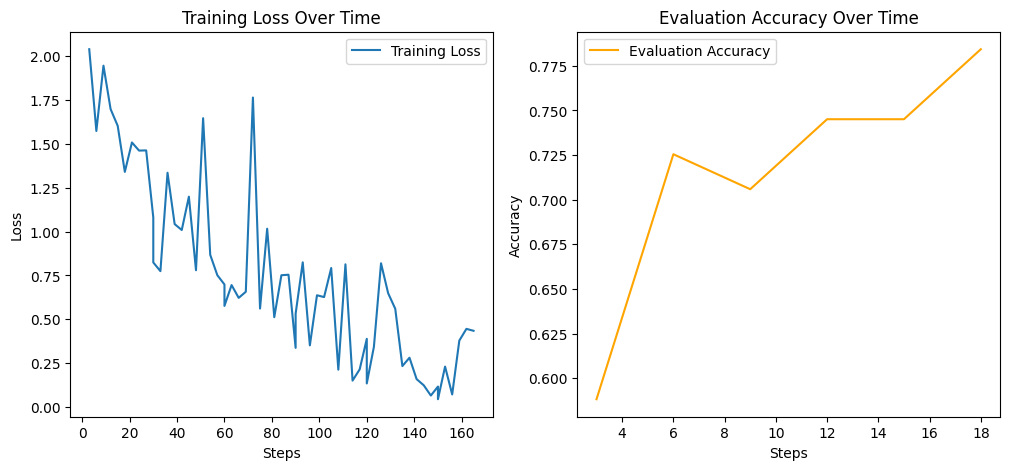

In [41]:
plot_training(llama_trainer)